In [18]:
%matplotlib inline
import numpy as np
import os
import pycs3.gen.lc_func
import pycs3.gen.mrg
import pycs3.spl.topopt
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc
import pycs3.gen.util
import pycs3.sim.draw
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
import pycs3.tdcomb.plot
import pycs3.tdcomb.comb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
loggerformat='%(message)s'
logging.basicConfig(format=loggerformat,level=logging.INFO)

plt.rcParams.update({'text.usetex': True})


In [20]:
rdbfile = '../data/RXJ1131_Tewes2013.txt'
rxj1131_lcs = [
        pycs3.gen.lc_func.rdbimport(rdbfile, object='A', magcolname='mag_A', magerrcolname='magerr_A', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='B', magcolname='mag_B', magerrcolname='magerr_B', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='C', magcolname='mag_C', magerrcolname='magerr_C', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='D', magcolname='mag_D', magerrcolname='magerr_D', telescopename='RXJ1131')
]

pycs3.gen.util.multilcsexport(rxj1131_lcs, separator='\t', filepath='../../rxj1131_pipeline/data/RXJ1131_dataset.rdb', rdbunderline=True)

Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/A] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/B] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/C] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/D] with 707 points imported (0 of them masked).
Wrote the lightcurves into ../../rxj1131_pipeline/data/RXJ1131_dataset.rdb


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[RXJ1131/A]
707 points (total), 0 of which are masked
9 seasons (gap: >60), gap length : 132.1 +/- 12.5 days
Sampling : median 2.0, mean 2.9, max 26.9, min 0.00 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : red
Common properties : airmass, fwhm, nbimg, normcoeff, telescope
   All properties : airmass, fwhm, nbimg, normcoeff, telescope
Comments :
   Imported from RXJ1131_Tewes2013.txt, columns (1, 2, 3)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


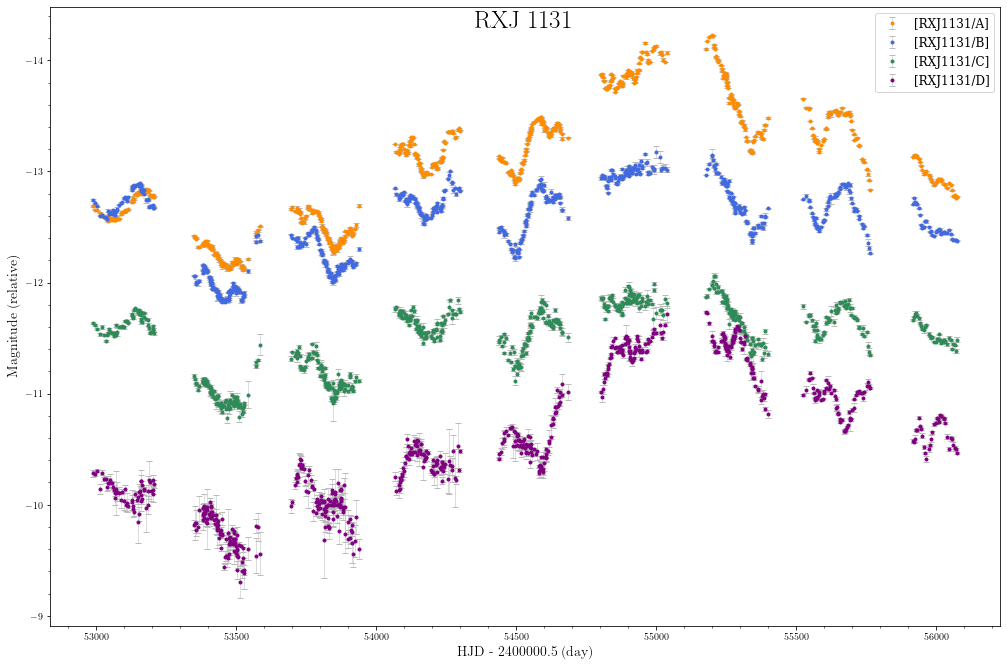

In [3]:
print(rxj1131_lcs[0].longinfo())
pycs3.gen.mrg.colourise(rxj1131_lcs)
pycs3.gen.lc_func.display(rxj1131_lcs, figsize=(15,10), nicefont=True, title=r'$\mathrm{RXJ\ 1131}$')

C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

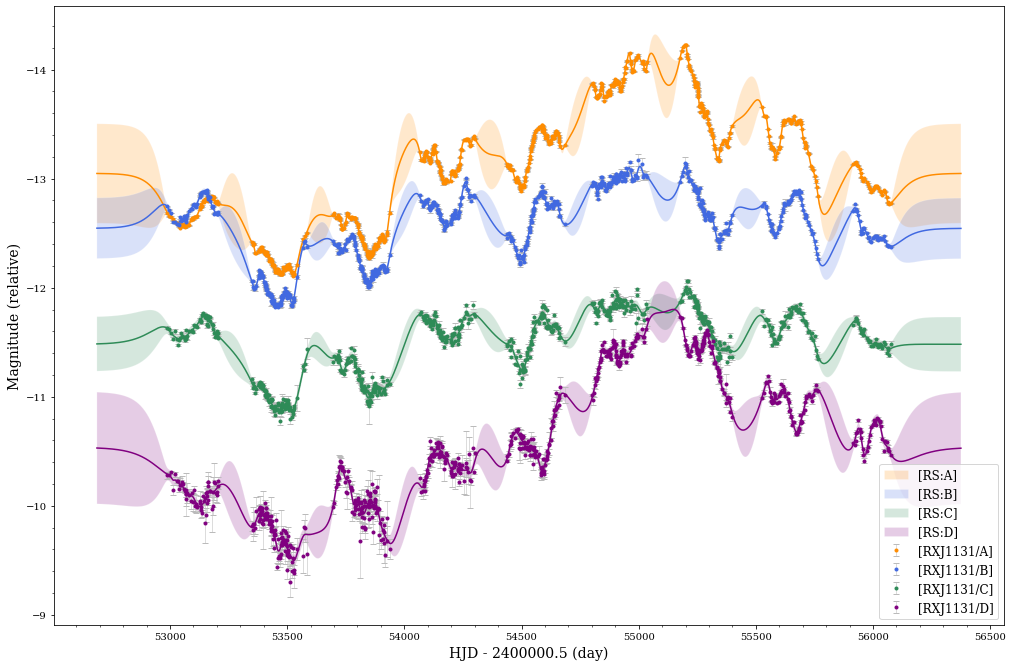

In [4]:
# Gaussian process fit
            
kwargs_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1, 'verbose': True, 'method': 'weights'}

rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'], 
                                    pow=kwargs_reg['pow'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(15,10))

In [5]:
# Timeshift optimization

# Optimization function
def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], pow=kwargs['pow'],
                                        errscale=kwargs['errscale'], verbose=False, method='weights')

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
#                                          timeshift           magshift
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0., 2., 2., -90.], [0.,0.,0.,0.])  

rslcs, error_fct = regdiff(rxj1131_lcs, pd=2, covkernel='matern', pow=1.5,errscale=1)

print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

Time delays:
AB =   +0.50
AC =   +0.00
AD =  -91.72
BC =   -0.50
BD =  -92.22
CD =  -91.72


C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

Text(0, 0.5, '$m_A - m_D$ \n $\\mathrm{(mag)}$')

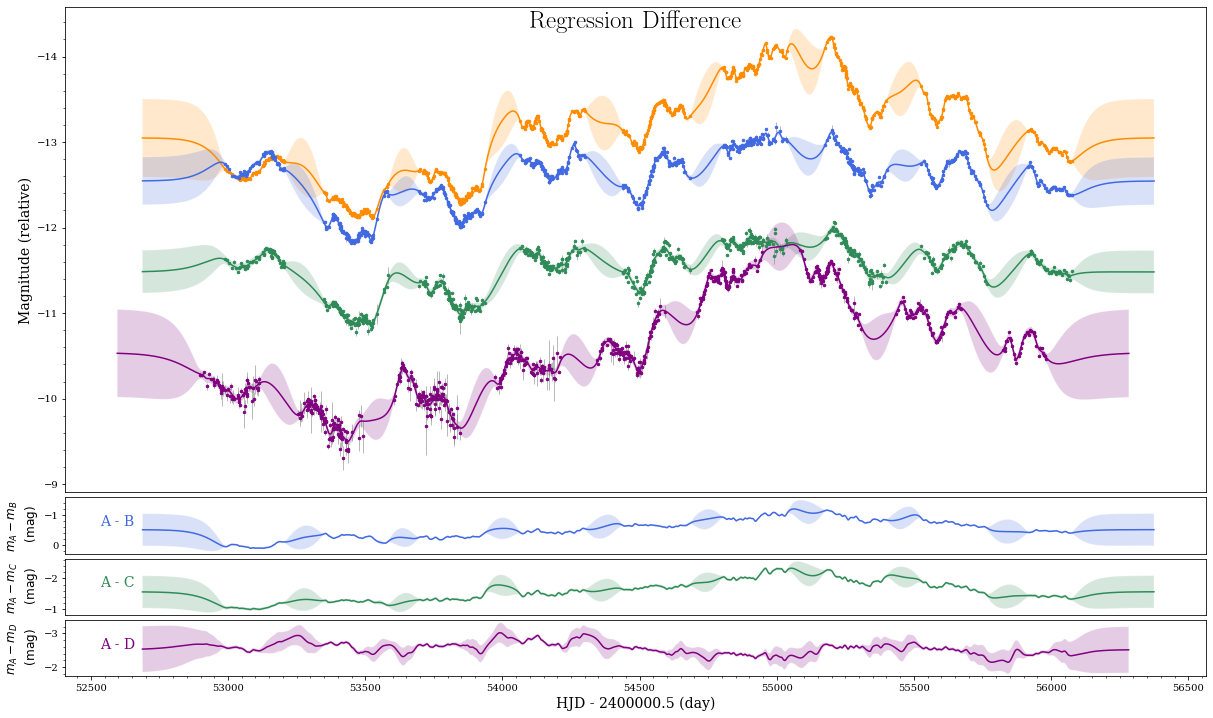

In [6]:
# Light curves already timeshifted
rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                   pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

rslcs_residuals = [pycs3.regdiff.rslc.subtract(rslcs[0],rslcs[i]) for i in [1,2,3]]

# Figure panel
fig1 = plt.figure(figsize=(18,10))
gs1 = gridspec.GridSpec(11,2)
gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
ax1 = plt.subplot(gs1[:8, :])
ax2 = plt.subplot(gs1[8:9, :], sharex=ax1)
ax3 = plt.subplot(gs1[9:10, :], sharex=ax1)
ax4 = plt.subplot(gs1[10:11, :], sharex=ax1)

# colorize residuals curves
for j, lc in enumerate(rslcs_residuals):
    lc.plotcolour = rxj1131_lcs[j+1].plotcolour
    
# prepare legend for different curves
disptext = []
for j, lc in enumerate(rslcs_residuals):
    ycoord = 0.5
    xcoord = 0.03
    kwargs = {'fontsize': 14, 'color': rxj1131_lcs[j+1].plotcolour}
    txt = f'A - {rxj1131_lcs[j+1].object}'
    disptext.append((xcoord, ycoord, txt, kwargs))
    
# plot light curves, regressions, and differences curves
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, showdelays=False, showlegend=False,
                         title=r'$\mathrm{Regression\ Difference }$', filename='screen', ax=ax1, style='cosmograil_dr1')
pycs3.gen.lc_func.display([], [rslcs_residuals[0]], showdelays=False, showlegend=False, filename='screen', ax=ax2, style='cosmograil_dr1', text=[disptext[0]])
pycs3.gen.lc_func.display([], [rslcs_residuals[1]], showdelays=False, showlegend=False, filename='screen', ax=ax3, style='cosmograil_dr1', text=[disptext[1]])
pycs3.gen.lc_func.display([], [rslcs_residuals[2]], showdelays=False, showlegend=False, filename='screen', ax=ax4, style='cosmograil_dr1', text=[disptext[2]])

# adjust the axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[1].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[2].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax4.set_ylabel('Regression Difference \n Residuals (mag)', fontsize=9)
ax4.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[3].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)

In [7]:
# Save optimized curves in pickle file
pycs3.gen.util.writepickle([rxj1131_lcs, rslcs], "../data/optcurves.pkl")

Wrote ../data/optcurves.pkl


In [8]:
# Drawing copies
simfolder="../data/sim"

if not os.path.isdir(simfolder):
    os.mkdir(simfolder)
    
lcs, rslcs = pycs3.gen.util.readpickle("../data/optcurves.pkl")
pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=2, simset='copies', destpath=simfolder)

Read ../data/optcurves.pkl
Now thowing dice into ../data/sim\sims_copies ...
The directory exists, I'll add my new curves.
Input shifts :
A    +0.00 | B    +0.50 | C    +0.00 | D   -91.72
Input delays :
AB =   +0.50 | AC =   +0.00 | AD =  -91.72 | BC =   -0.50 | BD =  -92.22 | CD =  -91.72
Preparing 10 identical copies for pkl 1/2 ...
Wrote ../data/sim\sims_copies\1_1614876484.14319.pkl
Preparing 10 identical copies for pkl 2/2 ...
Wrote ../data/sim\sims_copies\2_1614876484.34223.pkl


In [9]:
kwargs_opt_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1, 'scale': 200, 'errscale': 1}

success_dic = pycs3.sim.run.multirun('copies', lcs, regdiff, kwargs_opt_reg, optset='reg', tsrand=10.0, keepopt=True, destpath=simfolder)

I have found 8 simulation pickles in ../data/sim\sims_copies.
I'll write my results into the directory ../data/sim\sims_copies_opt_reg.
(The latter already exists.)
Initial conditions : 
[RXJ1131/A]
[RXJ1131/B](0.500,0.000,0)
[RXJ1131/C]
[RXJ1131/D](-91.716,0.000,0)
--- Casino running on simset copies, optset reg ---
Read ../data/sim\sims_copies\1_1614876484.14319.pkl
Working for ../data/sim\sims_copies_opt_reg\1_1614876484.14319_runresults.pkl, 10 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value

Reading 6 runresult pickles...
OK, I have collected 60 runs from Regression difference technique
Wrote ../data/sim\sims_copies_opt_reg_delays.pkl
Plotting "Regression difference technique (Measured, 60) "
     Labels : A, B, C, D
     Median shifts : -1.41, -0.89, -1.53, -93.13
     Std shifts : 5.29, 5.28, 5.29, 5.29


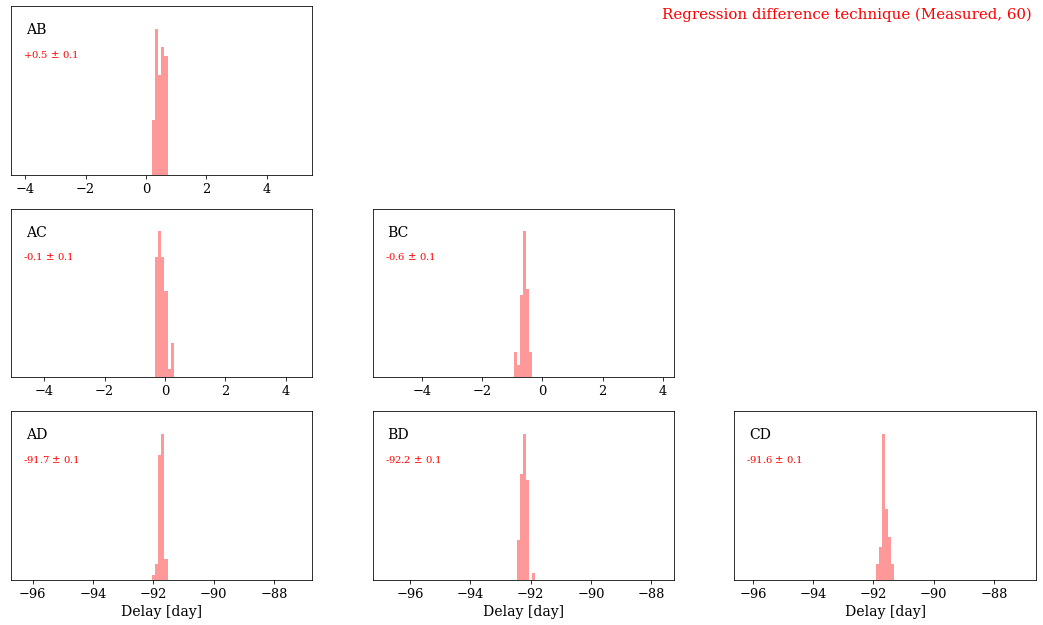

In [10]:
dataresults = [
    pycs3.sim.run.collect(directory=os.path.join(simfolder, 'sims_copies_opt_reg'), plotcolour='red', name='Regression difference technique')
]

pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=simfolder)

In [ ]:
# Mock light curve generation
